Bloque 0: Carga de Bibliotecas y funciones necesarias para el poyecto

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from collections import Counter
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier


# Pasos para instalación:
#
# 1. Instalar las librerías de Python usando pip:
#   pip install pandas numpy matplotlib nltk spacy scikit-learn seaborn
#
# 2. Descargar el modelo de idioma para spacy:
#   python -m spacy download en_core_web_sm
#
# 3. Verifica o Agregar la variable de entorno PATH
#   "C:\\Users\\TU_USUARIO\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\Scripts"
#
# 4. Si Pylance o el servidor de lenguaje Python de VS Code no detectan correctamente los módulos instalados:
#   - Reiniciar el servidor de lenguaje de Python a través de la paleta de comandos:
#     Python: Restart Language Server

Bloque 1: Carga Librerías, Datos y Preprocesamiento.

Palabras originales: 82870
Palabras después del preprocesamiento: 50687
Palabras eliminadas: 32183
Porcentaje de palabras eliminadas: 38.84%


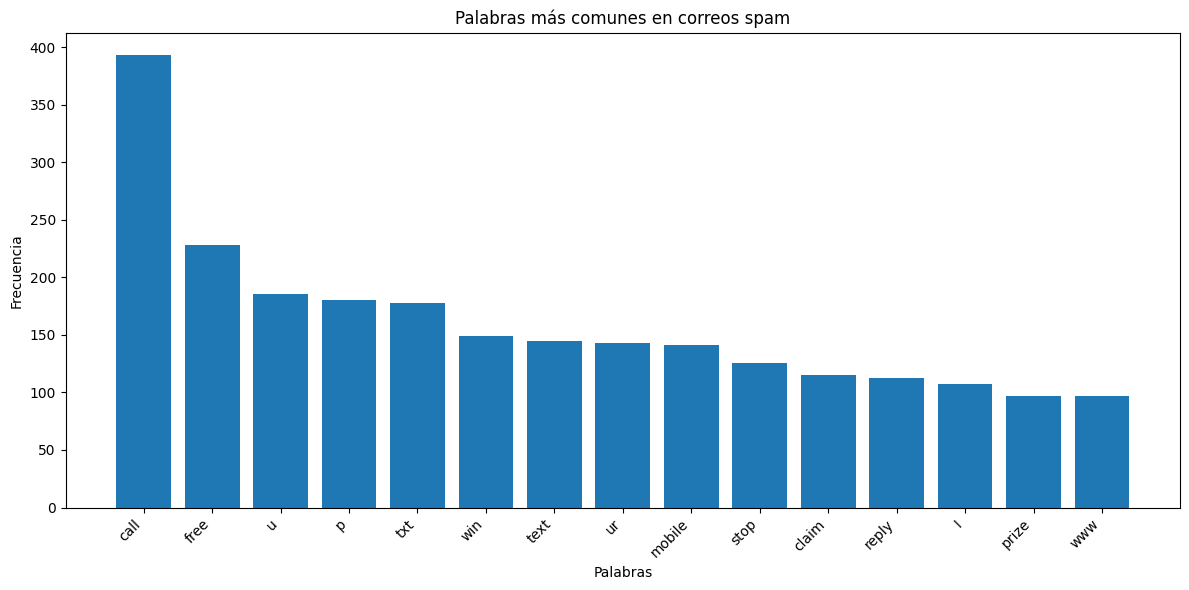

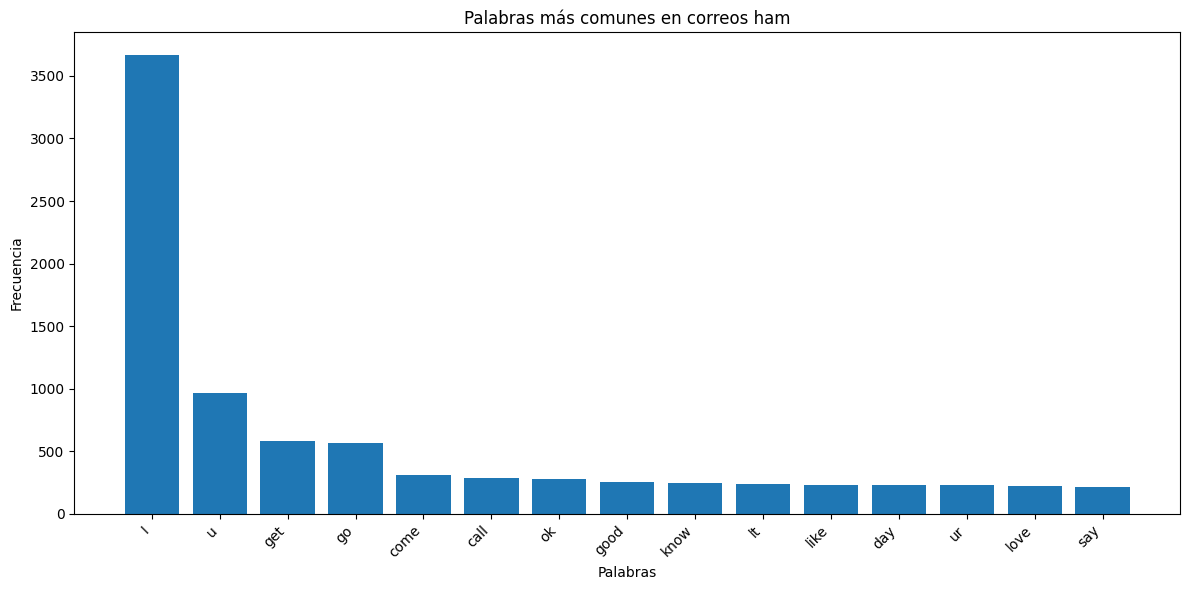

In [2]:
# Descargar stopwords
nltk.download('stopwords', quiet=True)

# Cargar modelo spaCy para lematización
nlp = spacy.load('en_core_web_sm')

# Cargar la base de datos
df = pd.read_csv('spam.csv', usecols=['v1', 'v2'], delimiter=';', encoding='latin-1')

# Renombrar columnas
df.columns = ['label', 'mensaje']

# Convertir las etiquetas en 0 para ham (no spam) y 1 para spam
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Eliminar valores faltantes
df = df.dropna()

# Definir stopwords
stop_words = set(stopwords.words('english'))

# Función de preprocesamiento y lematización
def preprocesar_y_lematizar(text):
    # Convertir a cadena y minúsculas
    text = str(text).lower()
    # Eliminar números, puntuación y caracteres especiales
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Procesar texto con spaCy y lematizar excluyendo stopwords
    doc = nlp(text)
    lemmatized = [token.lemma_ for token in doc if token.lemma_ not in stop_words and token.lemma_.strip() != '']
    return ' '.join(lemmatized)

# Contar palabras originales antes del preprocesamiento
palabras_originales = df['mensaje'].str.split().apply(len).sum()

# Aplicar preprocesamiento a los mensajes
df['mensaje_lemmatized'] = df['mensaje'].apply(preprocesar_y_lematizar)

# Contar palabras después del preprocesamiento
palabras_preprocesadas = df['mensaje_lemmatized'].str.split().apply(len).sum()

# Calcular estadísticas de palabras eliminadas
palabras_eliminadas = palabras_originales - palabras_preprocesadas
porcentaje_eliminado = (palabras_eliminadas / palabras_originales) * 100

# Imprimir estadísticas
print(f"Palabras originales: {palabras_originales}")
print(f"Palabras después del preprocesamiento: {palabras_preprocesadas}")
print(f"Palabras eliminadas: {palabras_eliminadas}")
print(f"Porcentaje de palabras eliminadas: {porcentaje_eliminado:.2f}%")

# Función para obtener las palabras más comunes
def obtener_palabras_comunes(data, label, n=15):
    palabras = ' '.join(data[data['label'] == label]['mensaje_lemmatized']).split()
    contador_palabras = Counter(palabras)
    palabras_comunes = contador_palabras.most_common(n)
    return palabras_comunes

# Palabras más comunes en correos spam
palabras_comunes_spam = obtener_palabras_comunes(df, 1, n=15)

# Palabras más comunes en correos ham (no spam)
palabras_comunes_ham = obtener_palabras_comunes(df, 0, n=15)

# Función para graficar las palabras más comunes
def graficar_palabras_comunes(palabras_comunes, title):
    palabras, frecuencias = zip(*palabras_comunes)
    plt.figure(figsize=(12, 6))
    plt.bar(palabras, frecuencias)
    plt.title(title)
    plt.xlabel('Palabras')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Graficar las palabras más comunes en correos spam (15 palabras)
graficar_palabras_comunes(palabras_comunes_spam, 'Palabras más comunes en correos spam')

# Graficar las palabras más comunes en correos ham (15 palabras)
graficar_palabras_comunes(palabras_comunes_ham, 'Palabras más comunes en correos ham')

# Dividir los datos en entrenamiento y prueba después del preprocesamiento 
X_train_full, X_test_full, y_train, y_test = train_test_split(df['mensaje_lemmatized'], df['label'], test_size=0.2, random_state=42)


Bloque 2: Justificación empírica para la selección de palabras.

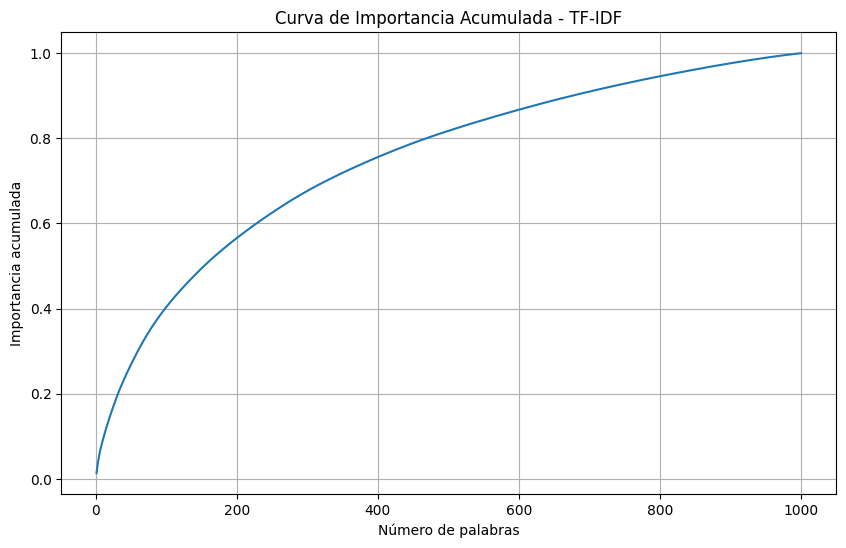

TF-IDF: Se necesitan 327 palabras para capturar el 70.0% de la importancia acumulada.
TF-IDF: Se necesitan 469 palabras para capturar el 80.0% de la importancia acumulada.
TF-IDF: Se necesitan 676 palabras para capturar el 90.0% de la importancia acumulada.


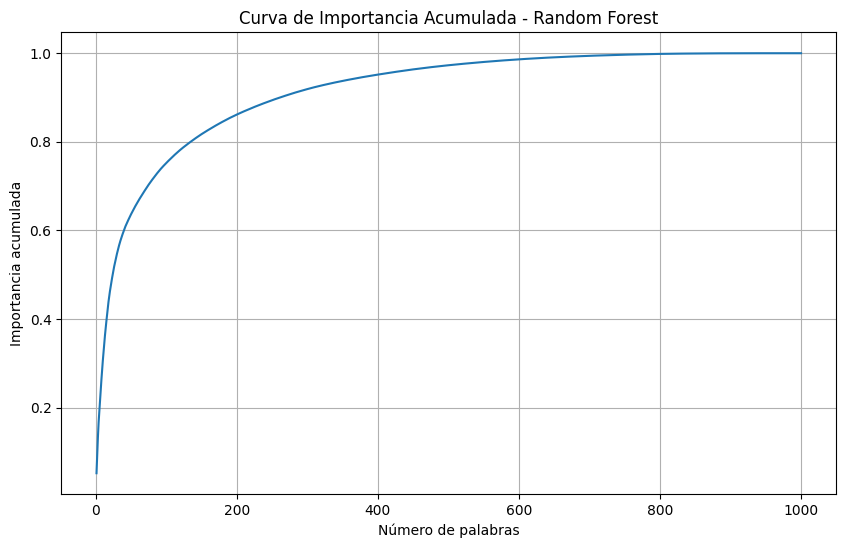

Random Forest: Se necesitan 74 palabras para capturar el 70.0% de la importancia acumulada.
Random Forest: Se necesitan 135 palabras para capturar el 80.0% de la importancia acumulada.
Random Forest: Se necesitan 261 palabras para capturar el 90.0% de la importancia acumulada.


In [3]:
# Vectorización con TF-IDF usando solo los datos de entrenamiento
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_full)

# Aplicar el vectorizador entrenado en los datos de prueba
X_test_tfidf = tfidf_vectorizer.transform(X_test_full)

# Obtener importancia acumulada con TF-IDF
word_importances_tfidf = X_train_tfidf.sum(axis=0).A1
sorted_importances_tfidf = sorted(zip(tfidf_vectorizer.get_feature_names_out(), word_importances_tfidf), key=lambda x: x[1], reverse=True)

# Gráfico de importancia acumulada de palabras para TF-IDF
total_importance_tfidf = sum(importance for _, importance in sorted_importances_tfidf)
cumulative_importance_tfidf = [sum(importance for _, importance in sorted_importances_tfidf[:i+1]) / total_importance_tfidf for i in range(len(sorted_importances_tfidf))]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_importance_tfidf) + 1), cumulative_importance_tfidf)
plt.title('Curva de Importancia Acumulada - TF-IDF')
plt.xlabel('Número de palabras')
plt.ylabel('Importancia acumulada')
plt.grid(True)
plt.show()

# Mostrar cuántas palabras capturan el 70%, 80%, y 90% de la importancia acumulada
percentages = [0.70, 0.80, 0.90]
for p in percentages:
    num_words = next(i for i, imp in enumerate(cumulative_importance_tfidf) if imp >= p) + 1
    print(f"TF-IDF: Se necesitan {num_words} palabras para capturar el {p*100}% de la importancia acumulada.")

# Random Forest para selección de palabras importantes usando solo los datos de entrenamiento
vectorizer_rf = CountVectorizer(max_features=1000)
X_train_rf = vectorizer_rf.fit_transform(X_train_full)

rf_model = RandomForestClassifier()
rf_model.fit(X_train_rf, y_train)

importances_rf = rf_model.feature_importances_
sorted_importances_rf = sorted(zip(vectorizer_rf.get_feature_names_out(), importances_rf), key=lambda x: x[1], reverse=True)

# Gráfico de importancia acumulada de palabras para Random Forest
cumulative_importance_rf = [sum(importance for _, importance in sorted_importances_rf[:i+1]) for i in range(len(sorted_importances_rf))]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_importance_rf) + 1), cumulative_importance_rf)
plt.title('Curva de Importancia Acumulada - Random Forest')
plt.xlabel('Número de palabras')
plt.ylabel('Importancia acumulada')
plt.grid(True)
plt.show()

# Mostrar cuántas palabras capturan el 70%, 80%, y 90% de la importancia acumulada
for p in percentages:
    num_words = next(i for i, imp in enumerate(cumulative_importance_rf) if imp >= p) + 1
    print(f"Random Forest: Se necesitan {num_words} palabras para capturar el {p*100}% de la importancia acumulada.")


BLOQUE 3: Evaluación de los Modelos Bernoulli y Multiniomial Naive Bayes

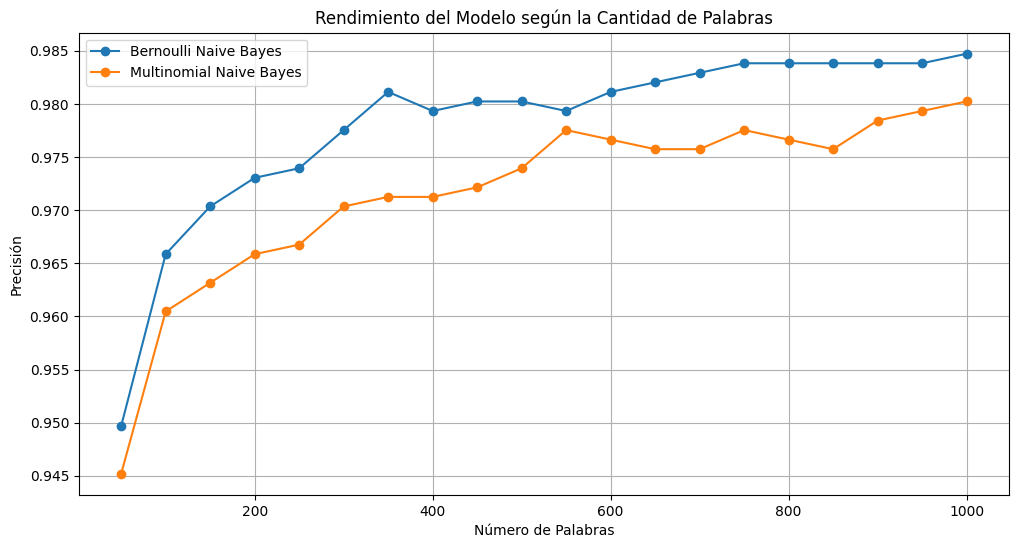

In [4]:
# Evaluar el rendimiento del modelo según la cantidad de palabras
def evaluar_modelo_según_palabras(n_palabras, vectorizer_type='tfidf'):
    accuracies_bernoulli = []
    accuracies_multinomial = []

    for n in n_palabras:
        if vectorizer_type == 'tfidf':
            vectorizer = TfidfVectorizer(max_features=n)
        else:
            vectorizer = CountVectorizer(max_features=n)
        
        # Vectorizar
        X_train = vectorizer.fit_transform(X_train_full)
        X_test = vectorizer.transform(X_test_full)
        
        # Modelo Bernoulli
        bernoulli_model = BernoulliNB()
        bernoulli_model.fit(X_train, y_train)
        y_pred_bernoulli = bernoulli_model.predict(X_test)
        accuracies_bernoulli.append(accuracy_score(y_test, y_pred_bernoulli))
        
        # Modelo Multinomial
        multinomial_model = MultinomialNB()
        multinomial_model.fit(X_train, y_train)
        y_pred_multinomial = multinomial_model.predict(X_test)
        accuracies_multinomial.append(accuracy_score(y_test, y_pred_multinomial))
    
    return accuracies_bernoulli, accuracies_multinomial

# Probar con diferentes números de palabras
n_palabras = range(50, 1001, 50)
accuracies_bernoulli, accuracies_multinomial = evaluar_modelo_según_palabras(n_palabras, vectorizer_type='tfidf')

# Graficar el rendimiento de los modelos según la cantidad de palabras
plt.figure(figsize=(12, 6))
plt.plot(n_palabras, accuracies_bernoulli, label='Bernoulli Naive Bayes', marker='o')
plt.plot(n_palabras, accuracies_multinomial, label='Multinomial Naive Bayes', marker='o')
plt.title('Rendimiento del Modelo según la Cantidad de Palabras')
plt.xlabel('Número de Palabras')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()


BLOQUE 4: Evaluación según niveles de Importancia Acumulada

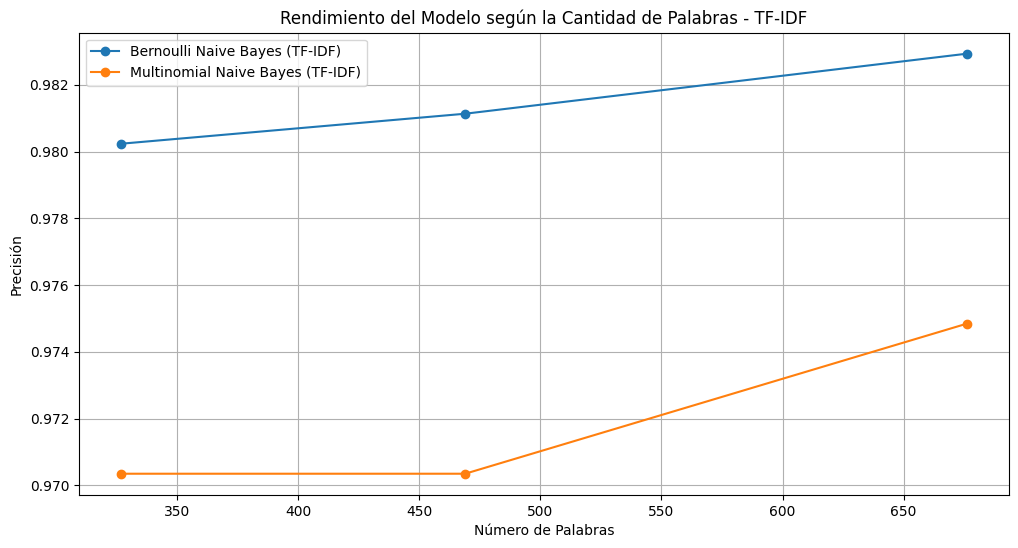

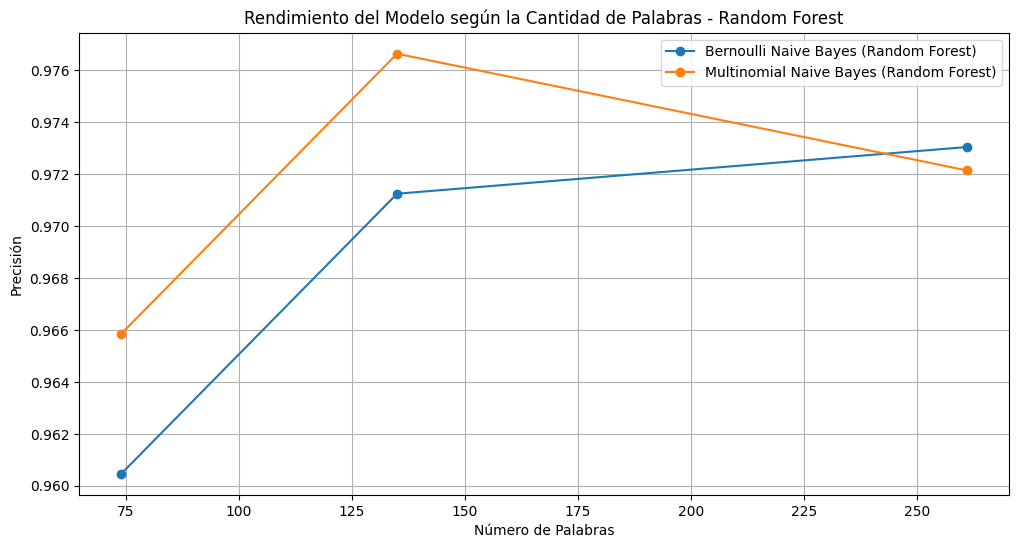

In [5]:
# Determinar la cantidad de palabras para diferentes niveles de importancia acumulada
def obtener_cantidad_palabras_por_importancia(cumulative_importance, percentages):
    cantidades = []
    for percentage in percentages:
        num_palabras = next(i for i, imp in enumerate(cumulative_importance) if imp >= percentage) + 1
        cantidades.append(num_palabras)
    return cantidades

# Niveles de importancia acumulada
percentages = [0.70, 0.80, 0.90]

# Cantidad de palabras para TF-IDF y Random Forest en cada nivel de importancia acumulada
cantidades_palabras_tfidf = obtener_cantidad_palabras_por_importancia(cumulative_importance_tfidf, percentages)
cantidades_palabras_rf = obtener_cantidad_palabras_por_importancia(cumulative_importance_rf, percentages)

# Evaluar modelos para TF-IDF
accuracies_bernoulli_tfidf, accuracies_multinomial_tfidf = evaluar_modelo_según_palabras(cantidades_palabras_tfidf, vectorizer_type='tfidf')

# Evaluar modelos para Random Forest
accuracies_bernoulli_rf, accuracies_multinomial_rf = evaluar_modelo_según_palabras(cantidades_palabras_rf, vectorizer_type='count')

# Graficar el rendimiento de los modelos según la cantidad de palabras
plt.figure(figsize=(12, 6))
plt.plot(cantidades_palabras_tfidf, accuracies_bernoulli_tfidf, label='Bernoulli Naive Bayes (TF-IDF)', marker='o')
plt.plot(cantidades_palabras_tfidf, accuracies_multinomial_tfidf, label='Multinomial Naive Bayes (TF-IDF)', marker='o')
plt.title('Rendimiento del Modelo según la Cantidad de Palabras - TF-IDF')
plt.xlabel('Número de Palabras')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(cantidades_palabras_rf, accuracies_bernoulli_rf, label='Bernoulli Naive Bayes (Random Forest)', marker='o')
plt.plot(cantidades_palabras_rf, accuracies_multinomial_rf, label='Multinomial Naive Bayes (Random Forest)', marker='o')
plt.title('Rendimiento del Modelo según la Cantidad de Palabras - Random Forest')
plt.xlabel('Número de Palabras')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()


BLOQUE 5: Conclusión y Matrices de Confusión


--- Resultados Bernoulli con TF-IDF ---
Precisión total del modelo Bernoulli con 327 palabras (tfidf): 0.9802
Precisión total del modelo Bernoulli con 469 palabras (tfidf): 0.9811
Precisión total del modelo Bernoulli con 676 palabras (tfidf): 0.9829

--- Resultados Bernoulli con Count Vectorizer ---
Precisión total del modelo Bernoulli con 74 palabras (count): 0.9605
Precisión total del modelo Bernoulli con 135 palabras (count): 0.9712
Precisión total del modelo Bernoulli con 261 palabras (count): 0.9730

--- Resultados Multinomial con TF-IDF ---
Precisión total del modelo Multinomial con 327 palabras (tfidf): 0.9704
Precisión total del modelo Multinomial con 469 palabras (tfidf): 0.9704
Precisión total del modelo Multinomial con 676 palabras (tfidf): 0.9748

--- Resultados Multinomial con Count Vectorizer ---
Precisión total del modelo Multinomial con 74 palabras (count): 0.9659
Precisión total del modelo Multinomial con 135 palabras (count): 0.9766
Precisión total del modelo Multino

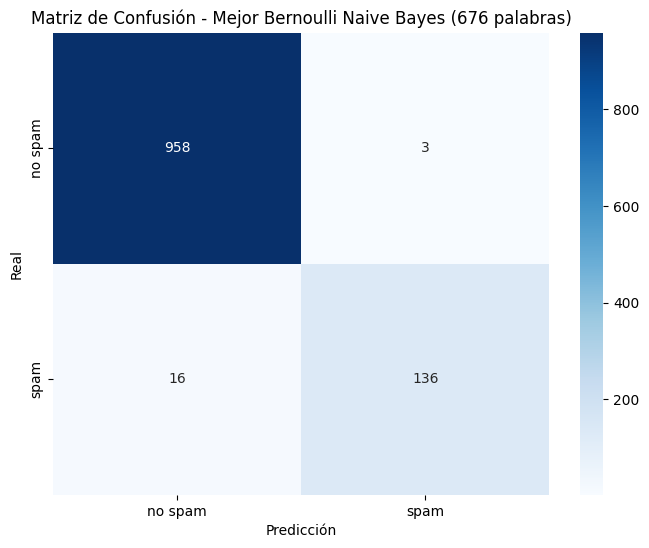

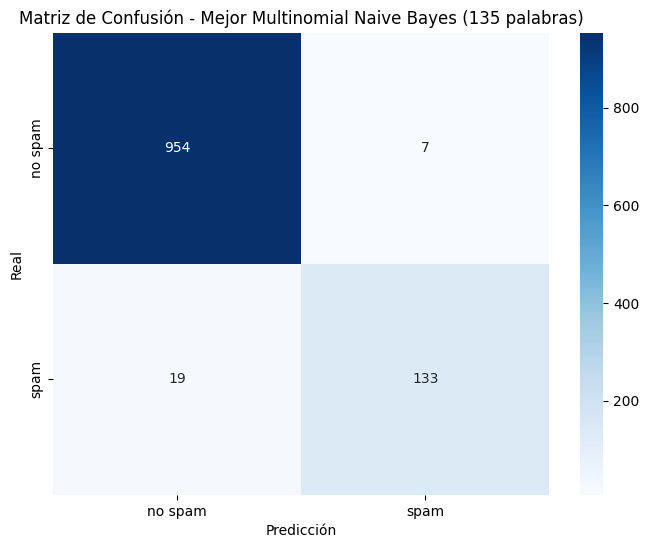

In [6]:
# Determinar la cantidad de palabras para diferentes niveles de importancia acumulada
def obtener_cantidad_palabras_por_importancia(cumulative_importance, percentages):
    cantidades = []
    for percentage in percentages:
        num_palabras = next(i for i, imp in enumerate(cumulative_importance) if imp >= percentage) + 1
        cantidades.append(num_palabras)
    return cantidades

# Asumimos que cumulative_importance_tfidf y cumulative_importance_rf están pre-calculados
# Niveles de importancia acumulada
percentages = [0.70, 0.80, 0.90]

# Cantidad de palabras para TF-IDF y Random Forest en cada nivel de importancia acumulada
cantidades_palabras_tfidf = obtener_cantidad_palabras_por_importancia(cumulative_importance_tfidf, percentages)
cantidades_palabras_rf = obtener_cantidad_palabras_por_importancia(cumulative_importance_rf, percentages)

# Almacenar los resultados para imprimir después
resultados_bernoulli_tfidf = []
resultados_multinomial_tfidf = []
resultados_bernoulli_count = []
resultados_multinomial_count = []

# Función para correr los modelos y almacenar las precisiones
def correr_modelos(cantidades_palabras, vectorizer_type='tfidf'):
    for n in cantidades_palabras:
        if vectorizer_type == 'tfidf':
            vectorizer = TfidfVectorizer(max_features=n)
        else:
            vectorizer = CountVectorizer(max_features=n)
        
        # Vectorizar
        X_train = vectorizer.fit_transform(X_train_full)
        X_test = vectorizer.transform(X_test_full)

        # Modelo Bernoulli
        bernoulli_model_opt = BernoulliNB()
        bernoulli_model_opt.fit(X_train, y_train)
        y_pred_bernoulli_opt = bernoulli_model_opt.predict(X_test)
        precision_bernoulli_total = accuracy_score(y_test, y_pred_bernoulli_opt)
        
        # Modelo Multinomial
        multinomial_model_opt = MultinomialNB()
        multinomial_model_opt.fit(X_train, y_train)
        y_pred_multinomial_opt = multinomial_model_opt.predict(X_test)
        precision_multinomial_total = accuracy_score(y_test, y_pred_multinomial_opt)
        
        # Guardar resultados según el tipo de vectorizador
        if vectorizer_type == 'tfidf':
            resultados_bernoulli_tfidf.append((n, precision_bernoulli_total, y_pred_bernoulli_opt))
            resultados_multinomial_tfidf.append((n, precision_multinomial_total, y_pred_multinomial_opt))
        else:
            resultados_bernoulli_count.append((n, precision_bernoulli_total, y_pred_bernoulli_opt))
            resultados_multinomial_count.append((n, precision_multinomial_total, y_pred_multinomial_opt))

# Correr modelos para TF-IDF
correr_modelos(cantidades_palabras_tfidf, vectorizer_type='tfidf')

# Correr modelos para Random Forest
correr_modelos(cantidades_palabras_rf, vectorizer_type='count')

### Mostrar los resultados previos como solicitaste
print("\n--- Resultados Bernoulli con TF-IDF ---")
for n, precision, _ in resultados_bernoulli_tfidf:
    print(f"Precisión total del modelo Bernoulli con {n} palabras (tfidf): {precision:.4f}")

print("\n--- Resultados Bernoulli con Count Vectorizer ---")
for n, precision, _ in resultados_bernoulli_count:
    print(f"Precisión total del modelo Bernoulli con {n} palabras (count): {precision:.4f}")

print("\n--- Resultados Multinomial con TF-IDF ---")
for n, precision, _ in resultados_multinomial_tfidf:
    print(f"Precisión total del modelo Multinomial con {n} palabras (tfidf): {precision:.4f}")

print("\n--- Resultados Multinomial con Count Vectorizer ---")
for n, precision, _ in resultados_multinomial_count:
    print(f"Precisión total del modelo Multinomial con {n} palabras (count): {precision:.4f}")

# Encontrar el mejor resultado para Bernoulli y Multinomial
def encontrar_mejor_resultado(resultados):
    # Ordenar por precisión, y luego por menor número de palabras
    mejor_resultado = sorted(resultados, key=lambda x: (-x[1], x[0]))[0]
    return mejor_resultado

# Mejor resultado para Bernoulli
mejor_bernoulli_tfidf = encontrar_mejor_resultado(resultados_bernoulli_tfidf)
mejor_bernoulli_count = encontrar_mejor_resultado(resultados_bernoulli_count)

# Mejor resultado para Multinomial
mejor_multinomial_tfidf = encontrar_mejor_resultado(resultados_multinomial_tfidf)
mejor_multinomial_count = encontrar_mejor_resultado(resultados_multinomial_count)

# Comparar y determinar el mejor resultado para Bernoulli
mejor_bernoulli = mejor_bernoulli_tfidf if mejor_bernoulli_tfidf[1] >= mejor_bernoulli_count[1] else mejor_bernoulli_count

# Comparar y determinar el mejor resultado para Multinomial
if mejor_multinomial_tfidf[1] == mejor_multinomial_count[1]:
    mejor_multinomial = mejor_multinomial_count if mejor_multinomial_count[0] < mejor_multinomial_tfidf[0] else mejor_multinomial_tfidf
else:
    mejor_multinomial = mejor_multinomial_tfidf if mejor_multinomial_tfidf[1] > mejor_multinomial_count[1] else mejor_multinomial_count

# Imprimir las conclusiones
print("\n--- Conclusión Final ---")
print(f"El mejor resultado para el modelo Bernoulli se logró con {mejor_bernoulli[0]} palabras ({'tfidf' if mejor_bernoulli == mejor_bernoulli_tfidf else 'count'}): {mejor_bernoulli[1]:.4f}")
print(f"El mejor resultado para el modelo Multinomial se logró con {mejor_multinomial[0]} palabras ({'tfidf' if mejor_multinomial == mejor_multinomial_tfidf else 'count'}): {mejor_multinomial[1]:.4f}")

# Graficar la matriz de confusión del mejor modelo Bernoulli
etiquetas = ['no spam', 'spam']
cm_bernoulli = confusion_matrix(y_test, mejor_bernoulli[2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bernoulli, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
plt.title(f'Matriz de Confusión - Mejor Bernoulli Naive Bayes ({mejor_bernoulli[0]} palabras)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Graficar la matriz de confusión del mejor modelo Multinomial
cm_multinomial = confusion_matrix(y_test, mejor_multinomial[2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_multinomial, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
plt.title(f'Matriz de Confusión - Mejor Multinomial Naive Bayes ({mejor_multinomial[0]} palabras)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()
